# Анализ интернет-магазина, запуск A/B-теста

Проект посвящен анализу текущих заказов и выбору путей увеличения прибыли крупного интернет-магазина.
Для этого имеющиеся гипотезы будут приоритизированы, осуществлен A/B-тест и проанализированы результаты, на основе чего предложены потенциальные рекомендации для дальнейших действий со стороны магазина. 

Данные:


в распоряжении аналитика три датасета: параметры приоритизации гипотез; характеристики заказов (1197 кейсов) и визитов (62 кейса). Данные - за август 2019 г.

Анализ будет строиться на расчетах показателей выручки, конверсии, количества заказов, стоимостей заказов, выявлении статистической значимости различий выручки и конверсии между двумя группами. Данные расчеты осуществляются на сырых и очищенных от выбросов данных.

Рзультаты данных расчетов позволят принять решение о необходимости продолжения A/B-теста.

## Загрузка данных и подготовка их к анализу

In [1]:
#Импортируем нужные библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import datetime as dt
from scipy import stats as st


In [2]:
# загрузим данные 
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),  # hypothesis
    pd.read_csv('/datasets/orders.csv'),  # orders
    pd.read_csv('/datasets/visitors.csv') #visitors
)

In [3]:
hypothesis.head(5)  

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
# show the full hypothesis
hypothesis['hypothesis'].value_counts()

Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар             1
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа    1
Запустить акцию, дающую скидку на товар в день рождения                                                         1
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                        1
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей              1
Запустить собственную службу доставки, что сократит срок доставки заказов                                       1
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию            1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок                1
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей        

In [7]:
pd.options.display.max_colwidth = 150
hypothesis['hypothesis']

0              Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1                                       Запустить собственную службу доставки, что сократит срок доставки заказов
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3             Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4                                Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5                        Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6            Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7                Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8                                                         Запустить акцию, дающую скидку

In [8]:
hypothesis.min()

hypothesis    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
reach                                                                                                                    1
impact                                                                                                                   1
confidence                                                                                                               1
efforts                                                                                                                  1
dtype: object

In [9]:
hypothesis.max()

hypothesis    Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
reach                                                                                                           10
impact                                                                                                          10
confidence                                                                                                       9
efforts                                                                                                         10
dtype: object

In [10]:
orders.head(5)  

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [12]:
orders.columns = orders.columns.str.lower()

In [13]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [15]:
orders.duplicated().sum() 

0

In [16]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [17]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

In [18]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [19]:
visitors.duplicated().sum() 

0

In [20]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [21]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [22]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [23]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

<div class="alert alert-block alert-info">
    В предварительной работе с данными нами был приведен формат переменных к единому регистру, временные переменные приведены к нужному формату, осуществлена проверка на дубликаты, рассмотрены полные формулировки гипотез.

## Приоритизация гипотез

### ICE

In [24]:
# ICE score = (Impact x Confidence) / Efforts
hypothesis['ICE'] =  hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
print(hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending = False))

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

### RICE

In [25]:
# RICE = (Reach x Impact x Confidence)/Efforts
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
print(hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending = False))

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

### Выводы по приоритизации

In [26]:
print(hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values('ICE', ascending = False))

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

<div class="alert alert-block alert-info">
    По параметру  ICE наиболее приоритетна гипотеза "Запустить акцию, дающую скидку на товар в день рождения", по параметру RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Если первый параметр позволяет выявить гипотезу с потенциалом наибольшего влияния на покупателей и уверенности в ее эффективности, то RICE учитывает характеристику охвата аудитории, при этом лидер гипотезы по ICE сильно отстает по показаелю охвата от других пипотез. Лидер RICE в тоже время может состоит в тройке лидеров по ICE. Поэтому наиболее приоритетной можно считать гипотезу "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

 ## Анализ A/B-теста

### График кумулятивной выручки по группам

<div class="alert alert-block alert-info">
Найдем заказчиков, фигурирующих в двух группах одновременно, и удалим эти кейсы из базы заказчиков

In [27]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [28]:
orders.query('group=="B"')['visitorid'].isin(orders.query('group=="A"')['visitorid']).sum()


92

In [29]:
double = orders.groupby('visitorid')['group'].nunique().reset_index().query('group>1')['visitorid']

In [30]:
orders = orders[~orders['visitorid'].isin(double)]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


<div class="alert alert-block alert-info">
    Создадим отдельную базу данных, в которой для каждого заказа определенной даты и группы теста рассчитана общая выручка

In [31]:
datesGroups = orders[['date', 'group']]
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

ordersAggregated.groupby('date').head(5)


,date,group,revenue
55,2019-08-01,A,142779
72,2019-08-01,A,142779
73,2019-08-01,A,142779
96,2019-08-01,A,142779
98,2019-08-01,A,142779
...,...,...,...
958,2019-08-31,A,3364656
996,2019-08-31,A,3364656
1010,2019-08-31,A,3364656
1011,2019-08-31,A,3364656


In [32]:
# датафрейм с кумулятивной выручкой по дням в группе А
cumulativeRevenueA = ordersAggregated[ordersAggregated['group']=='A'][['date','revenue']]

In [33]:
# датафрейм с кумулятивной выручкой по дням в группе В
cumulativeRevenueB = ordersAggregated[ordersAggregated['group']=='B'][['date','revenue']]

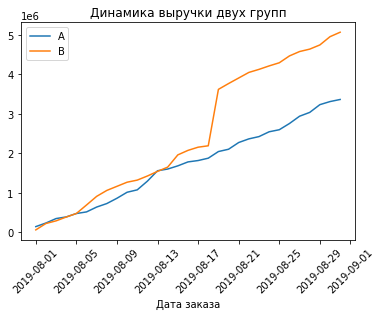

In [34]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Динамика выручки двух групп')  # название графика
plt.xlabel('Дата заказа')  # название оси X
plt.xticks(rotation=45)  # угол наклона подписей на оси X
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    График кумулятивной выручки по группам демонстрирует, что примерно до 12 августа общая выручка позаказам двух групп - была примерно идентичной, но во второй половине месяца заказы группы В вырываются вперед и показываются гораздо большую прибыль, чем А.

### График кумулятивного среднего чека по группам

In [35]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


<div class="alert alert-block alert-info">
Поскольку для расчетов среднего чека нам необходимо знать число заказов (и в будущем- покупателей), сформируем расширенную аналогичную базу с добавлением переменных заказов и покупателей

In [36]:
ordersAggregated = datesGroups.apply(
	lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


In [37]:
ordersAggregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 55 to 1038
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1016 non-null   datetime64[ns]
 1   group          1016 non-null   object        
 2   transactionid  1016 non-null   int64         
 3   visitorid      1016 non-null   int64         
 4   revenue        1016 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [38]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [39]:
visitors.sort_values('date')

,date,group,visitors
0,2019-08-01,A,719
31,2019-08-01,B,713
1,2019-08-02,A,619
32,2019-08-02,B,581
2,2019-08-03,A,507
...,...,...,...
28,2019-08-29,A,577
60,2019-08-30,B,490
29,2019-08-30,A,490
30,2019-08-31,A,699


<div class="alert alert-block alert-info">
    Также создаем базу для посетителей

In [40]:
visitorsAggregated = datesGroups.apply(
	lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


In [41]:
datesGroups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1016 non-null   datetime64[ns]
 1   group   1016 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 23.8+ KB


In [42]:
visitorsAggregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 55 to 1038
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1016 non-null   datetime64[ns]
 1   group     1016 non-null   object        
 2   visitors  1016 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 31.8+ KB


<div class="alert alert-block alert-info">
    Объединим две базы заказов и посетителей

In [43]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.head(5)

,date,group,transactionid,visitorid,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,A,23,19,142779,719
2,2019-08-01,A,23,19,142779,719
3,2019-08-01,A,23,19,142779,719
4,2019-08-01,A,23,19,142779,719


In [44]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [45]:
cumulativeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18144 entries, 0 to 18143
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      18144 non-null  datetime64[ns]
 1   group     18144 non-null  object        
 2   orders    18144 non-null  int64         
 3   buyers    18144 non-null  int64         
 4   revenue   18144 non-null  int64         
 5   visitors  18144 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 992.2+ KB


In [46]:
cumulativeData.sample(5)

,date,group,orders,buyers,revenue,visitors
6955,2019-08-10,B,198,195,1268123,6277
13291,2019-08-22,B,401,388,4050134,13524
15501,2019-08-27,A,419,400,2940471,16376
8856,2019-08-14,A,231,218,1601692,9058
7132,2019-08-11,A,181,169,1074396,6980


<div class="alert alert-block alert-info">
    Разделим базу по группам и выберем нужные для графика переменные. Чтобы получить средний чек - разделим выручку на число заказов

In [47]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

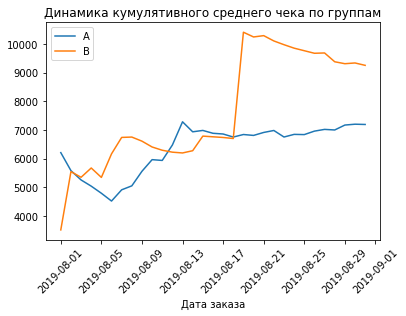

In [48]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата заказа')  # название оси X
plt.title('Динамика кумулятивного среднего чека по группам')  # название графика
plt.xticks(rotation=45)  # угол наклона подписей на оси X
plt.legend()


<div class="alert alert-block alert-info">
График динамики кумулятивного среднего чека по группам показывает, что во второй половине августа группа В также начинает лидировать, хотя и в первых числах августа видно доминирование В, но затем следует скачок А, который постепенно снижается.

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [49]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


No handles with labels found to put in legend.


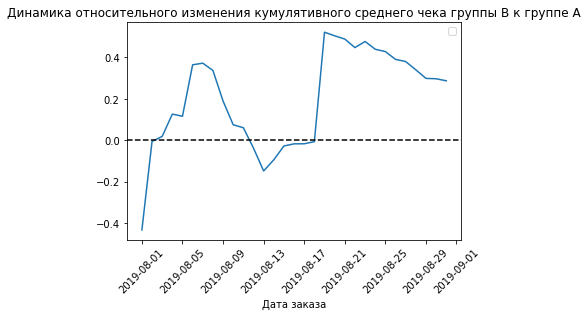

In [50]:
plt.plot(
	mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
)
plt.legend()
plt.xlabel('Дата заказа')  # название оси X
plt.title('Динамика относительного изменения кумулятивного среднего чека группы B к группе A')  # название графика
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')


<div class="alert alert-block alert-info">
     График относительного изменения кумулятивного среднего чека группы B к группе A показывает, что практически на всем исследуемом периоде, за исключением первых числе и промежутка 10-17 августа, выручка группы В в относительном выражении превышала выручку группы А.

### График кумулятивной конверсии по группам

In [51]:
# воспользуемся нашей подной объединенной базой для расчета конверсии
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
# отделяем данные по группе Bta[cumulativeData['group']=='B']


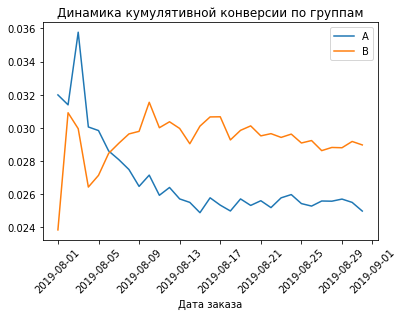

In [52]:
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xlabel('Дата заказа')  # название оси X
plt.title('Динамика кумулятивной конверсии по группам')  # название графика
plt.xticks(rotation=45)
plt.legend()


<div class="alert alert-block alert-info">
    График кумулятивной конверсии по группам показывает, что посетители из группы В чаще конвертировались, этот тренд после некоторых колебаний в начале установился примерно после 5 августа: конверсия В примерно варьируется на уровне 30%

### График относительного изменения кумулятивной конверсии группы B к группе A

In [53]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# отобрали нужные переменные по двуз групповым базам и объединили их

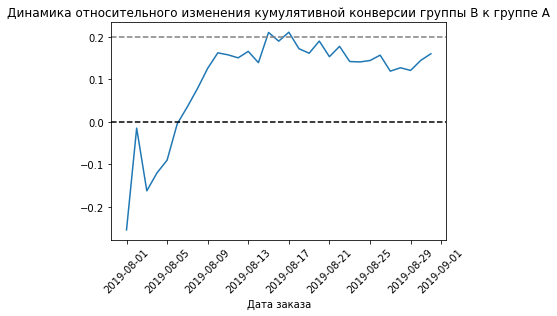

In [54]:
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xlabel('Дата заказа')  # название оси X
plt.title('Динамика относительного изменения кумулятивной конверсии группы B к группе A')  # название графика
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')


<div class="alert alert-block alert-info">
    График относительного изменения кумулятивной конверсии группы B к группе A показывает, что конвертация покупателей группы В выше, чем А, различия в конверсиях достигают 20% относительно пользователей В

### Точечный график количества заказов по пользователям

In [55]:
#Подсчитаем количество заказов по пользователям:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']


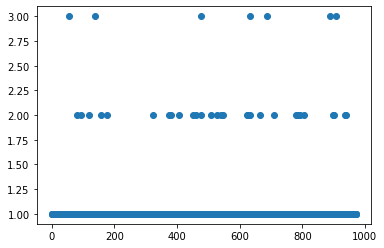

In [56]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])


<div class="alert alert-block alert-info">
    Пользователи совершали в основном 1-2 покупки

### 95-й и 99-й перцентили количества заказов на пользователя

In [57]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))


[1. 2.]


<div class="alert alert-block alert-info">
    95% всех покупателей совершали не более одной покупки, 99% всех покупателей совершали не более двух покупок

### Точечный график стоимостей заказов

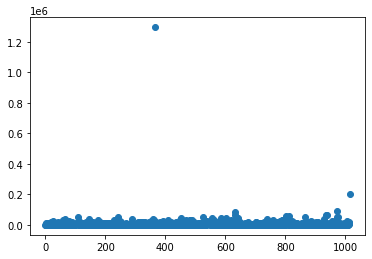

In [58]:
x_values2 = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values2, orders['revenue'])


<div class="alert alert-block alert-info">
    Точечный график стоимостей заказов - не столь демонстративен с точки зрения однородности стоимостей заказов, но видно для что некоторых пользователей наблюдаются выбросы

### 95-й и 99-й перцентили стоимости заказов

In [59]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


<div class="alert alert-block alert-info">
Менее 5% заказов превышали сумму 27 тысяч, менее 1% - выше 54 тысяч

<div class="alert alert-block alert-info">
Таким образом, на основании верхних границ перцентилей можно говорить о том, что более двух заказов на покупателя и суммы заказа выше 53904 тысяч можно считать выбросами.

### Cтатистическая значимость различий в конверсии между группами по «сырым» данным

<div class="alert alert-block alert-info">
    Для расчета значимости различий  - необходимо иметь в наличии две подвыборки, средние которых и будут сравниваться. Сформируем вначале две подвыборки заказов по группам.

In [60]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

In [61]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


In [62]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']


In [63]:
#Список с количеством заказов для каждого из пользователей + Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)


In [64]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']


In [65]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


<div class="alert alert-block alert-info">
    H0: конверсия группы А равна конверсии группы В
    
H1: конверсия группы А не равна конверсии группы В

In [66]:
import scipy.stats as stats
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.011


<div class="alert alert-block alert-info">
    P-value составляет 1,1% или менее 5% - значит, на уровне значимости 5% мы можем отвергнуть нулевую гипотезу.

In [67]:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


0.160


<div class="alert alert-block alert-info">
    
Средняя конверсия группы В отличается от средней конверсии группы А на 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

<div class="alert alert-block alert-info">
    H0: средний чек группы А равен среднему чеку группы В
    
H1: средний чек группы А не равен среднему чеку группы В

In [68]:
#Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))


0.829


<div class="alert alert-block alert-info">
 p-value = 0.829 и это больше 0.05. Значит, нулевую гипотезу не отвергаем, - нет оснований говорить о статистически знаимых различиях

In [69]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.287


<div class="alert alert-block alert-info">
Несмотря на то, что нет оснований говорить о статистически значимых различиях, относительные различия средних чеков составляют около 29%.

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

In [70]:
orders['userId'] = orders['visitorid']

<div class="alert alert-block alert-info">
Осуществим аналогичные шаги, что и делали выше, но предварительно создадим датафрейм с выбросами, интересующие нас пользователи не должны попасть в этот датафрейм

In [71]:
                      
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'],99)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'],99)]['userId'],
    ],
    axis=0,
)
 

In [72]:
                     
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'],99)]['userId']


In [73]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


In [74]:
abnormalUsers.sample(5)

310     2988190573
416     3967698036
743     4133034833
1103    1164614297
425     1920142716
Name: userId, dtype: int64

In [75]:
sampleAFiltered = pd.concat(
	[
    	ordersByUsersA[
        	np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
    	]['orders'],
    	pd.Series(
        	0,
        	index=np.arange(
            	visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
        	),
        	name='orders',
    	),
	],
	axis=0,
)



In [76]:
sampleAFiltered.describe()

count    18726.000000
mean         0.023924
std          0.157294
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: orders, dtype: float64

In [77]:
sampleBFiltered = pd.concat(
	[
    	ordersByUsersB[
        	np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
    	]['orders'],
    	pd.Series(
        	0,
        	index=np.arange(
            	visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
        	),
        	name='orders',
    	),
	],
	axis=0,
)


In [78]:
sampleBFiltered.sample(5)

3940     0
7508     0
6878     0
13967    0
11669    0
Name: orders, dtype: int64

<div class="alert alert-block alert-info">
На имеющихся двух базах - проверим статистическую значимость равенства конверсий

In [79]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

0.007


<div class="alert alert-block alert-info">
    Результат оценки статистической значимости на сырых данных совпадает с результатом оценки на очищенных данных: нулвевую гипотезу отвергнуть не можем, нет оснований говорить о том, что различй между конверсиями в двух группах нет

In [80]:
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.189


<div class="alert alert-block alert-info">
    По сравнению  с сырыми данными отличия конверсии группы В  от средней конверсии группы А стало выше (ранее - 16%) и составляет 19%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [81]:
print(
	'{0:.3f}'.format(
    	stats.mannwhitneyu(
        	orders[
            	np.logical_and(
                	orders['group'] == 'A',
                	np.logical_not(orders['userId'].isin(abnormalUsers)),
            	)
        	]['revenue'],
        	orders[
            	np.logical_and(
                	orders['group'] == 'B',
                	np.logical_not(orders['userId'].isin(abnormalUsers)),
            	)
        	]['revenue'],
    	)[1]
	)
)


0.788


<div class="alert alert-block alert-info">
    Результат проверки статистической значимости по очищенным от аномалий данным - не отличается от схожего результата по сырым данным: нет оснований отврегнуть нулевую гипотезу, поэтому можно говорить об отсутствии значимых статистических различий в средних чеках двух групп

In [82]:
print(
	"{0:.3f}".format(
    	orders[
        	np.logical_and(
            	orders['group'] == 'B',
            	np.logical_not(orders['userId'].isin(abnormalUsers)),
        	)
    	]['revenue'].mean()
    	/ orders[
        	np.logical_and(
            	orders['group'] == 'A',
            	np.logical_not(orders['userId'].isin(abnormalUsers)),
        	)
    	]['revenue'].mean()
    	- 1
	)
)


-0.032


<div class="alert alert-block alert-info">
    Однако очищенные данные предоставляют более правдоподобные данные относительных отличий средних чеков: расчет на  очищенных данных демонстрируют разницу чеков - в -3%.

## Выводы

<div class="alert alert-block alert-info">
    В проекте исследуются данные крупного интернет-магазина, в распоряжении аналитика имеется подготовленный отделом маркетинга список гипотез для увеличения выручки и данные об осуществленных заказах и посетителях магазина.
    Для последующих действий со стороны магазина и увеличения выручки от аналитика требуется выбрать приоритетную гипотезу и обосновать необходимость продолжения A/B-теста. Для этого проводится сравнение ключевых показателей выручки, среднего чека и конверсии в отношении групп А и В - на базе графического анализа и проверки статистически значимых различий в группах.
    
    
На основании сопоставления ICE и RICE наиболее приоритетной можно считать гипотезу "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
    
Графический анализ показал, что второй половине августа 2019 года заказы группы В вырываются вперед и показываются гораздо большую прибыль, чем А, аналогичное отставание А наблюдается и при сравнении средних чеков. Помимо этого, посетители из группы В чаще конвертировались: конверсия В примерно варьируется на уровне 30%, отставание группы А от В по конверсии достигает 20%. 
    
Средняя конверсия группы В статистически значимо отличается от средней конверсии группы А.
что верно и для очищенных от аномалий (на 19%), и для сырых данных. 
Относительные различия средних чеков В и А составляют около 29%, однако проверка статистически значимых различий с помощью критерия Манна-Уитни не выявила значимых различий между группами. 
    

На основании озвученных расчетов можно было бы порекомендовать завершить A/B-тест и признать наиболее выигрышной группу В, поскольку в этой группе и выручка больше, и конверсия выше и средний чек, рассчитанный на сырых данных ( то есть с учетом слишком больших чеков), превышает средний чек группы А. При этом статистика p-value, построенная на очищенных от аномалии данных, демонстрируют, что нет оснований говорить о различии средних чеков в группе А и В.
    